<a href="https://colab.research.google.com/github/cairoegito/HTML-e-CSS--Portfolio-/blob/main/Test_rede_neural_aulas_2e3_modulo3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
#Importando bibliotecas
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
from pathlib import Path
import PIL
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
import os
import matplotlib.pyplot as plt

In [16]:
# Montando o Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
#Diretorio com imagens
data_diretorio = "/content/drive/MyDrive/Rede Neural FLORES/flower_photos"

In [40]:
# Escolha um arquivo de imagem dentro do diretório
exemplo_imagem = os.path.join(data_diretorio, 'daisy', '100080576_f52e8ee070_n.jpg')
img = load_img(exemplo_imagem)
img_height, img_width = img.size

In [41]:
# Defina parâmetros para pré-processamento de imagens
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


In [42]:
# Carregue e pré-processe as imagens usando o ImageDataGenerator
train_ds = datagen.flow_from_directory(
    data_diretorio,
    target_size=(img_height, img_width),  # Usando as dimensões da imagem de exemplo
    batch_size=32,
    class_mode='categorical',
    subset="training"
)

Found 3670 images belonging to 5 classes.


In [43]:
# Carregando conjunto de validação
val_ds = datagen.flow_from_directory(
    data_diretorio,
    target_size=(img_height, img_width),  # Usando as dimensões da imagem de exemplo
    batch_size=32,
    class_mode='categorical',
    subset="validation"
)

Found 0 images belonging to 5 classes.


In [22]:
#Transformando diretorio de string para Path
data_diretorio = Path(data_diretorio)


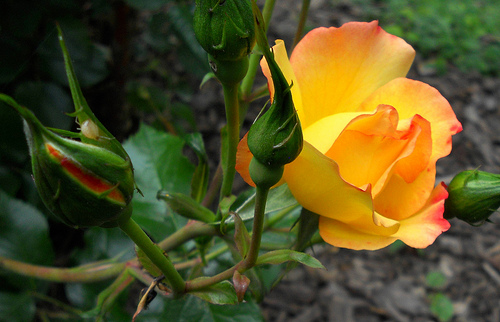

In [23]:
#Exemplo de rosa
roses = list(data_diretorio.glob('roses/*'))
PIL.Image.open(str(roses[0]))

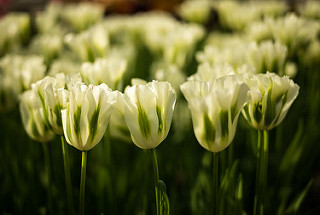

In [24]:
#Exemplo de tulipas
tulips = list(data_diretorio.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

In [25]:
#Observando as classes
class_indices = train_ds.class_indices
class_names = list(class_indices.keys())
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


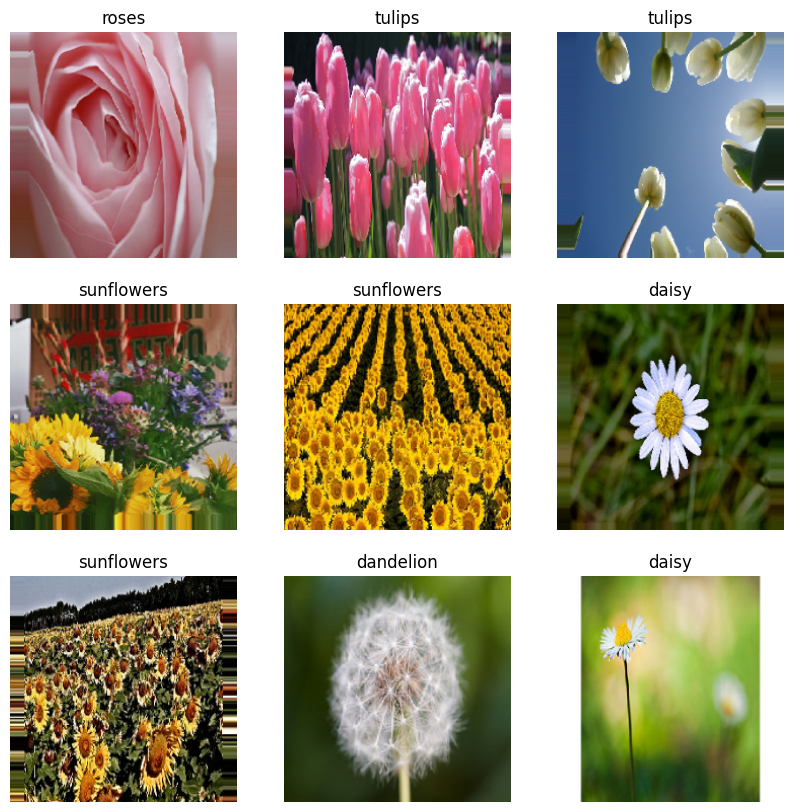

In [26]:
#Visualizando imagens iniciais
plt.figure(figsize=(10, 10))
for images, labels in train_ds:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i].argmax()])
        plt.axis("off")
    break

In [27]:
#Definindo número de classes
num_classe = len(train_ds.class_indices)


In [28]:
# Converta os geradores para tf.data.Dataset
train_ds = tf.data.Dataset.from_generator(
    lambda: train_ds,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, num_classe), dtype=tf.float32)
    )
)

val_ds = tf.data.Dataset.from_generator(
    lambda: val_ds,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, num_classe), dtype=tf.float32)
    )
)

In [29]:
#Impondo treinamento e teste, garantindo renovação a cada iteração mas armazenando fotos anteriores
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [30]:
#Padronizando a faixa RGB para [0,1]
normalization_layer = layers.Rescaling(1./255)


In [31]:
#Criando modelo com padronizações ideais
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classe)
])

In [32]:
#Compilando o modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
#Visualizando as camadas
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 320, 263, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 320, 263, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 160, 131, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 160, 131, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 80, 65, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 80, 65, 64)        1

In [44]:
#Treinando o modelo com epocas determinadas
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


InvalidArgumentError: ignored